In [167]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from IPython.display import Latex, display, Markdown

Saját adatok alapján, lehet energetikai, de más jellegű is, a lényeg a kapcsolatvizsgálat számszerűsítéss és értelmezése. Adatgyűjtés, probléma pontos megfogalmazása, megfelelő modell illesztése, eredmények értelmezése kb 3-5 oldal + adatok

Beadás április 30ig

# Módszertan II
Befektetéselemzési, árampiaci és gázpiaci példákkal

## 1. Leíró statisztika

In [2]:
otp= yf.download('OTP.BD')

[*********************100%***********************]  1 of 1 completed


In [3]:
otp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-03-05,2100.0,2190.0,2082.0,2190.0,1611.094604,1726700
2002-03-06,2177.0,2251.0,2151.0,2240.0,1647.877563,898300
2002-03-07,2261.0,2300.0,2241.0,2295.0,1688.338867,763700
2002-03-08,2265.0,2282.0,2243.0,2280.0,1677.303955,402000
2002-03-11,2254.0,2259.0,2151.0,2159.0,1588.289185,439600


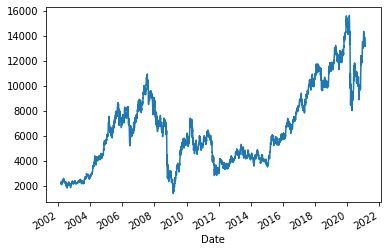

In [4]:
ax=otp.Close.plot()

In [5]:
#Hozam számolás
# egyszerű hozam
otp['simple_return'] = otp.Close.pct_change()
# log hozam
otp['log_return'] = np.log(otp.Close/otp.Close.shift(1))

In [6]:
otp.head()

,Open,High,Low,Close,Adj Close,Volume,simple_return,log_return
Date,,,,,,,,
2002-03-05,2100.0,2190.0,2082.0,2190.0,1611.094604,1726700,NaN,NaN
2002-03-06,2177.0,2251.0,2151.0,2240.0,1647.877563,898300,0.022831,0.022574
2002-03-07,2261.0,2300.0,2241.0,2295.0,1688.338867,763700,0.024554,0.024257
2002-03-08,2265.0,2282.0,2243.0,2280.0,1677.303955,402000,-0.006536,-0.006557
2002-03-11,2254.0,2259.0,2151.0,2159.0,1588.289185,439600,-0.053070,-0.054530


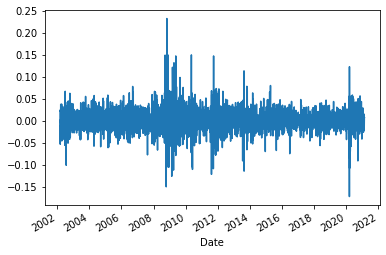

In [7]:
ax=otp.simple_return.plot()

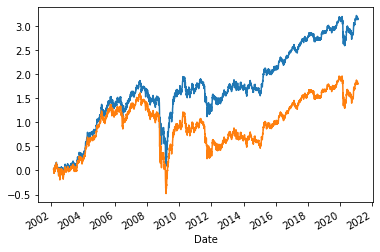

In [8]:
otp.simple_return.cumsum().plot()
ax=otp.log_return.cumsum().plot()

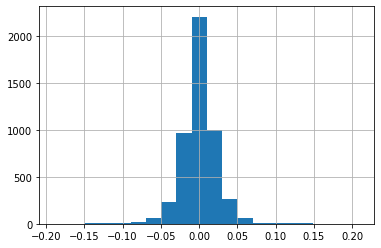

In [9]:
ax=otp.log_return.hist(bins=20)

In [10]:
otp.Close[0] * np.exp(len(otp)*otp.log_return.mean())

13354.957103741532

In [11]:
otp.Close[-1]

13350.0

In [41]:
otp.describe()

,Open,High,Low,Close,Adj Close,Volume,simple_return,log_return
count,4870.000000,4870.000000,4870.000000,4870.000000,4870.000000,4.870000e+03,4869.000000,4869.000000
mean,6449.761191,6525.545175,6367.589733,6447.859197,5687.833057,1.280074e+06,0.000647,0.000371
std,3118.937128,3145.055408,3093.452056,3120.287415,3233.329319,1.391902e+06,0.023487,0.023511
min,1320.000000,1500.000000,1232.000000,1355.000000,1098.250000,0.000000e+00,-0.172020,-0.188767
25%,4090.250000,4138.250000,4040.000000,4090.000000,3393.309814,4.691295e+05,-0.010795,-0.010853
50%,5821.000000,5886.000000,5750.000000,5819.000000,4891.771484,8.500675e+05,0.000000,0.000000
75%,8502.500000,8599.750000,8418.000000,8497.750000,7377.526855,1.581849e+06,0.012094,0.012022
max,15580.000000,15850.000000,15520.000000,15630.000000,15630.000000,2.669842e+07,0.232639,0.209157


In [13]:
print(f'Median:{otp.Close.median()} \nMode:\n{otp.Close.mode()}')

Median:5819.0 
Mode:
0    4150.0
1    4200.0
dtype: float64


In [45]:
print(f'A hozamok varianciája: {otp.log_return.var(ddof=0):.4f} Szórása:{otp.log_return.std():.2%}')

A hozamok varianciája: 0.0006 Szórása:2.35%


In [48]:
print(f'A hozamok ferdesége: {otp.log_return.skew():.3f}')

A hozamok ferdesége: -0.257


Sűrűségfüggvény
$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^\frac{(x-m)^2}{2\sigma^2}$

# 2. Villamosenergia day ahead árak és fogyasztás kapcsolatának vizsgálata
Ebben a részben a HUPX Day ahead árak és a magyar villamosenergia rendszer fogyasztási görbéjét vizsgálom, egy tetszőleges napra vonatkozólag. A DAM árak T-1 napi aukció során alakultak ki. 

In [59]:
# adatok letöltése az ENTSOE transparency platformról
# hupx jelöli a DAM árak tábláját, load pedig a terhelési adatokat.
import entsoapi
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key=entsoapi.mykey)

country_code = 'HU'
start = pd.Timestamp('202102150000', tz='Europe/Brussels')
end = pd.Timestamp('202102152345', tz='Europe/Brussels')

hupx = client.query_day_ahead_prices(country_code, start=start,end=end)
load=client.query_load(country_code, start=start,end=end)

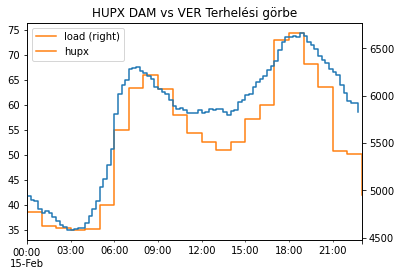

In [60]:
load.plot(secondary_y=True, drawstyle='steps-post', label='load', legend=True)
a = hupx.plot(drawstyle='steps-post', label='hupx', legend=True, 
              title =f'HUPX DAM vs VER Terhelési görbe')

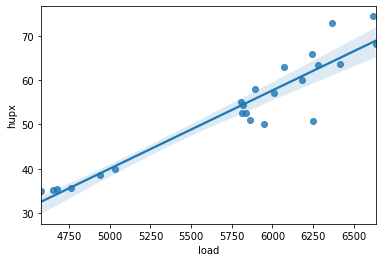

In [61]:
df = pd.DataFrame()
df['load'] = load
df['hupx'] = hupx
df.dropna(inplace=True)
ax = sns.regplot(x="load", y="hupx", data=df)

## Kétváltozós lineáris regressziós modell (kézi számolással)

X tengelyen a terhelési görbe ami az okozó tényező Y tengelyen a hupx DA árak.

$Y = \beta_0 + \beta_1X$

### Legkisebb négyzetek módszere
Munkatábla; az idősor tengelyre nincs szükség.

In [62]:
#X = load; Y= hupx
df['XiYi'] = df.load*df.hupx
df['Xi2'] = df.load*df.load
df.dropna()
df.head(3)

,load,hupx,XiYi,Xi2
2021-02-15 00:00:00+01:00,4942.0,38.53,190415.26,24423364.0
2021-02-15 01:00:00+01:00,4764.0,35.70,170074.80,22695696.0
2021-02-15 02:00:00+01:00,4676.0,35.42,165623.92,21864976.0


### Normálegyenletek megoldása determináns módszerrel

In [63]:
sumY = df.hupx.sum()
sumX2 = df['Xi2'].sum()
sumX = df.load.sum()
sumXY = df.XiYi.sum()
n = len(df)
b0= (sumY*sumX2-(sumX*sumXY))/(n*sumX2-(sumX*sumX))
b1 = (n*sumXY-sumY*sumX)/(n*sumX2-(sumX*sumX))
display(Latex(f'$\\beta_0:${b0:4f} $\\beta_1:${b1:4f}'))

<IPython.core.display.Latex object>

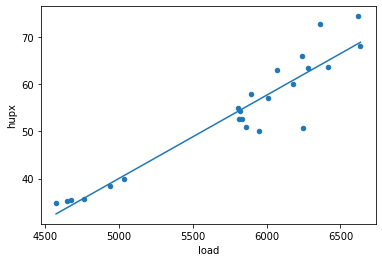

In [64]:
df.plot.scatter(x='load', y='hupx')
x_values = np.linspace(df.load.min(),df.load.max(),2)
y_linreg_values = b0+b1*x_values
ax=plt.plot(x_values,y_linreg_values)

In [65]:
print(f'A regressziófüggvény:Y = {b0:.2f} + {b1:.4f} X')
print(f'A villamosenergia fogyasztás 100 MWh-val való \
növekedése átlagosan {b1*100:.4f} EUR/MWh-val növelte \
a HUPX DA árait a vizsgált időszakban.')

A regressziófüggvény:Y = -48.28 + 0.0177 X
A villamosenergia fogyasztás 100 MWh-val való növekedése átlagosan 1.7656 EUR/MWh-val növelte a HUPX DA árait a vizsgált időszakban.


### Rugalmassági együttható: E(Y, X=5500)

In [66]:
X = 5500
E = b1 * X/(b0+b1*X)
print(f'Ha {X} MWh lett volna a fogyasztás és az 1%-kal nő, akkor az ár {E:.3f} EUR-ral nőne.')

Ha 5500 MWh lett volna a fogyasztás és az 1%-kal nő, akkor az ár 1.989 EUR-ral nőne.


### Lineáris korreláció szorossága

In [105]:
# covariance önmagában nem tul értelmes
df[['hupx', 'load']].cov()

,hupx,load
hupx,150.264585,7582.869012
load,7582.869012,429489.885375


In [68]:
# correlation normalizálja a covariance-t -1..+1 közé
df[['hupx', 'load']].corr()

,hupx,load
hupx,1.000000,0.943906
load,0.943906,1.000000


In [143]:
# ellenőrzés a scipy. stats-ból
import string
meredekség, tengelymetszet, r, pvalue, stderr = stats.linregress(df.load, df.hupx)

egyenlet = 'y = {:.2f}+{:.4f}x'.format(tengelymetszet,meredekség )
r = {'egyenlet': egyenlet,
    'r': f'{r:.4f}',
    'p': f'{p:.4f}',
    'stderr': f'{stderr:.4f}'}

report = string.Template("""
HUPX DAM ár és VER fogyasztási adatok közötti kapcsolatvizsgálat
Ellenőrzése scipy.stats-szal
=================================================
Regressziós egyenlet : $egyenlet
Korreláció (r)       : $r
p érték              : $p
standard hiba        : $stderr
""")
print(report.substitute(r))



HUPX DAM ár és VER fogyasztási adatok közötti kapcsolatvizsgálat
Ellenőrzése scipy.stats-szal
Regressziós egyenlet : y = -48.28+0.0177x
Korreláció (r)       : 0.9439
p érték              : 0.0000
standard hiba        : 0.0013



In [ ]:
#TODO: ide egy jo nagy összefoglaló elemzést a fentiekről

## 3. A BÉT néhány részvényének korrelációs mátrixa

*Probléma*: Itt találomra kiválasztottam 10 BÉTen forgó részvényt és a 2020-as adataik alapján a köztük 3-5 leginkább együttmozgót keresem (akár ellentétes irányban is).

In [115]:
data = yf.download("4IG.BD BIF.BD ALTEO.BD ANY.BD RABA.BD AKKO.BD DELTA.BD OTP.BD MOL.BD OPUS.BD", start="2020-01-01", end="2020-12-31")
data['Adj Close'].head(3)

,4IG.BD,AKKO.BD,ALTEO.BD,ANY.BD,BIF.BD,DELTA.BD,MOL.BD,OPUS.BD,OTP.BD,RABA.BD
Date,,,,,,,,,,
2020-01-02,678.775269,440.0,850.0,1296.597534,298.934845,127.0,2960.0,325.0,15390.0,1127.363647
2020-01-03,636.351807,438.0,882.0,1296.597534,299.902283,126.0,2950.0,322.0,15290.0,1127.363647
2020-01-06,652.742676,424.0,892.0,1287.336060,300.869720,123.0,2882.0,309.0,14640.0,1108.255859


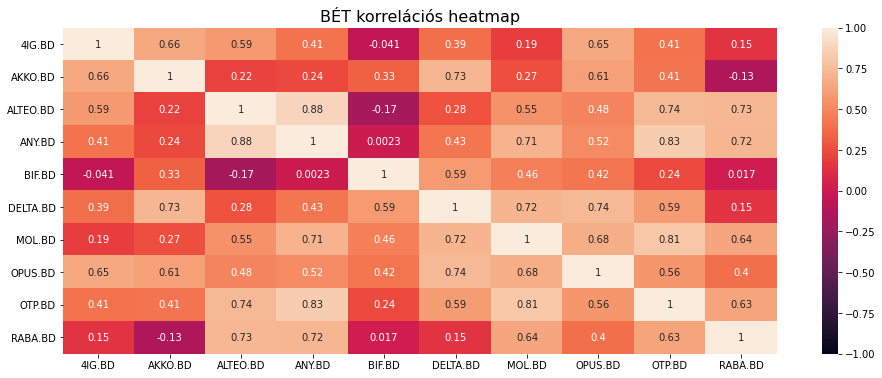

In [121]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data['Adj Close'].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('BÉT korrelációs heatmap', fontdict={'fontsize':16});

### TOP 5 legmagasabb korrelációs pár

In [148]:
def get_redundant_pairs(df):
    pairs_to_drop = set() # set-ben nem lehet ismétlődés
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top 5 legnagyobb absolut együttmozgó pár")
get_top_abs_correlations(data['Adj Close'],5)

Top 5 legnagyobb absolut korrelációs pár


ALTEO.BD  ANY.BD     0.880404
ANY.BD    OTP.BD     0.833676
MOL.BD    OTP.BD     0.805214
ALTEO.BD  OTP.BD     0.741396
DELTA.BD  OPUS.BD    0.735395
dtype: float64

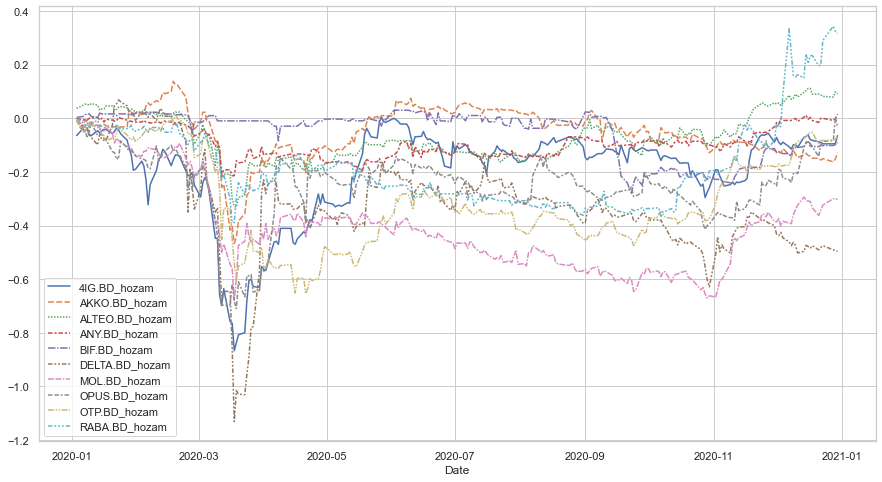

In [165]:
data2 = pd.DataFrame()
for c in data['Adj Close'].columns:
    colname = c+'_hozam'
    data2[colname] = np.log(data['Adj Close'][c]/data['Adj Close'][c].shift(1))

plt.figure(figsize=(15,8))
ax=sns.lineplot(data=data2.cumsum())

## 3. Beta, CAPM, Optimális portfólió

In [ ]:
Ebben a fejezetben kiszámítom a beruházáselemzés órán elhangzott példák alapján az OTP és ZWACK hozamait, betáját, 